In [41]:
!mkdir -p data/raw data/processed models src notebooks

In [42]:
!pip install pandas numpy scikit-learn lightgbm tldextract beautifulsoup4 fastapi uvicorn joblib

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
!mkdir -p /content/drive/MyDrive/AI_Phishing_Detector
%cd /content/drive/MyDrive/AI_Phishing_Detector

/content/drive/MyDrive/AI_Phishing_Detector


In [45]:
!mkdir -p data/raw data/processed models src notebooks

In [46]:
!pip install pandas numpy scikit-learn lightgbm tldextract beautifulsoup4 fastapi uvicorn joblib

In [47]:
import pandas as pd, numpy as np, sklearn, lightgbm, tldextract, bs4
print("✅ Environment ready. All dependencies loaded.")

✅ Environment ready. All dependencies loaded.


In [48]:
from pathlib import Path
import joblib
import pandas as pd

BASE_DIR = Path("/content/drive/MyDrive/AI_Phishing_Detector")
MODELS_DIR = BASE_DIR / "models"
DATA_DIR = BASE_DIR / "data" / "processed"

print("✅ Paths ready.")

✅ Paths ready.


In [49]:
import pandas as pd
import requests
import zipfile
import io
import os

# Paths
output_dir = "/content/drive/MyDrive/AI_Phishing_Detector/data/raw/"
output_file = os.path.join(output_dir, "legit_urls.csv")
os.makedirs(output_dir, exist_ok=True)

# Tranco top 1M list
tranco_url = "https://tranco-list.eu/top-1m.csv.zip"
r = requests.get(tranco_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
df = pd.read_csv(z.open('top-1m.csv'), header=None)
df = df.head(50000)  # take top 50k domains

# Convert domains to full URLs
df['url'] = "https://" + df[1]
df = df[['url']]

# Save
df.to_csv(output_file, index=False)
print(f"Saved {len(df)} legitimate URLs to {output_file}")

Saved 50000 legitimate URLs to /content/drive/MyDrive/AI_Phishing_Detector/data/raw/legit_urls.csv


In [50]:
import pandas as pd
import os

# Paths
output_dir = "/content/drive/MyDrive/AI_Phishing_Detector/data/processed/"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "live_dataset.csv")

# Load raw data
phish = pd.read_csv("/content/drive/MyDrive/AI_Phishing_Detector/data/raw/phishing_urls.csv")
legit = pd.read_csv("/content/drive/MyDrive/AI_Phishing_Detector/data/raw/legit_urls.csv")

# Assign labels
phish['label'] = 1
legit['label'] = 0

# Merge datasets
df = pd.concat([phish, legit], ignore_index=True)

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Remove duplicates (just in case)
df = df.drop_duplicates(subset=['url'])

# Save final dataset
df.to_csv(output_file, index=False)

# Quick verification
print(f"Final dataset shape: {df.shape}")
print("Class distribution:")
print(df['label'].value_counts())
df.head()

Final dataset shape: (99361, 2)
Class distribution:
label
0    49999
1    49362
Name: count, dtype: int64


,url,label
0,https://lukoil.com,0
1,https://nabble.com,0
2,https://l.ead.me/bfUXDb,1
3,https://cloudsink.net,0
4,https://ebu.ch,0


In [51]:
# src/feature_extraction.py
# Comprehensive, production-minded URL feature extractor for phishing detection.
# - URL-only lexical & structural features (no page fetch)
# - Optional light network checks (DNS resolve) controlled by perform_network_checks flag
# - Character-sequence encoder for Char-CNN (fixed length, padding/truncation)
# - Saves `features_df` and `char_seqs.npy` if asked
#
# Usage example (Colab):
#   from src.feature_extraction import build_features_for_df
#   df = pd.read_csv("/content/drive/MyDrive/AI_Phishing_Detector/data/processed/live_dataset.csv")
#   feats_df, char_seqs = build_features_for_df(df['url'], perform_network_checks=False, save_prefix="/content/drive/.../features")
#
import re
import os
import math
import json
import hashlib
import socket
from urllib.parse import urlparse, unquote
from collections import Counter
from typing import List, Tuple, Optional, Dict

import numpy as np
import pandas as pd
import tldextract

# ---------------------------
# Configuration / constants
# ---------------------------
CHAR_VOCAB = (
    list("abcdefghijklmnopqrstuvwxyz") +
    list("0123456789") +
    list(":/?&=.%-_+#@~")  # a compact set of common URL chars
)
# Add uppercase mapping to lowercase in tokenizer
CHAR_TO_INDEX = {c: i+1 for i, c in enumerate(CHAR_VOCAB)}  # reserve 0 for padding
UNK_CHAR_INDEX = len(CHAR_TO_INDEX) + 1
DEFAULT_MAX_LEN = 200

# Suspicious TLDs (expandable). Use as a binary indicator.
SUSPICIOUS_TLDS = {
    'xyz', 'top', 'club', 'online', 'site', 'website', 'pw', 'tk', 'ml', 'ga', 'cf', 'gq'
}

# Regexes
RE_IPv4 = re.compile(r'^(?:\d{1,3}\.){3}\d{1,3}$')
RE_IP_IN_HOST = re.compile(r'(^|\[)(\d{1,3}\.){3}\d{1,3}(\]|$)')
RE_PORT = re.compile(r':\d+$')
RE_PERCENT_ENCODE = re.compile(r'%[0-9a-fA-F]{2}')
RE_NON_ALNUM = re.compile(r'[^A-Za-z0-9]')

# ---------------------------
# Utility functions
# ---------------------------
def normalize_url(url: str) -> str:
    """Lowercase scheme & host. Strip surrounding whitespace. Keep path/query intact."""
    if not isinstance(url, str):
        return ""
    url = url.strip()
    if not url:
        return ""
    # ensure scheme present (default to https)
    if not re.match(r'^[a-zA-Z]+://', url):
        url = 'http://' + url  # use http to allow parsing; we keep original scheme presence as feature
    parsed = urlparse(url)
    # Rebuild with normalized netloc
    netloc = parsed.netloc.lower()
    rebuilt = parsed._replace(netloc=netloc).geturl()
    return rebuilt

def is_ip_host(host: str) -> int:
    if not host:
        return 0
    # strip possible port
    host_no_port = host.split(':')[0]
    if RE_IPv4.match(host_no_port):
        return 1
    # also check for encoded/ip formats inside host
    if RE_IP_IN_HOST.search(host):
        return 1
    return 0

def shannon_entropy(s: str) -> float:
    if not s:
        return 0.0
    counts = Counter(s)
    probs = [v/len(s) for v in counts.values()]
    return -sum(p * math.log2(p) for p in probs) if probs else 0.0

def count_special_chars(s: str) -> int:
    return len(RE_NON_ALNUM.findall(s))

def has_port(netloc: str) -> int:
    # netloc may contain ':port'
    if ':' in netloc and netloc.split(':')[-1].isdigit():
        return 1
    return 0

def extract_tld_info(domain: str) -> Tuple[str, str]:
    """Return (registered_domain, tld). registered_domain is e.g. example.co.uk -> example.co.uk"""
    if not domain:
        return "", ""
    te = tldextract.extract(domain)
    registered = ".".join(part for part in [te.domain, te.suffix] if part)
    return registered, te.suffix.lower() if te.suffix else ""

def percent_encoded_fraction(s: str) -> float:
    if not s:
        return 0.0
    matches = RE_PERCENT_ENCODE.findall(s)
    return len(matches) / max(1, len(s))

def count_digits(s: str) -> int:
    return sum(ch.isdigit() for ch in s)

def count_letters(s: str) -> int:
    return sum(ch.isalpha() for ch in s)

def vowel_fraction(s: str) -> float:
    if not s:
        return 0.0
    return sum(ch in 'aeiou' for ch in s.lower()) / max(1, len(s))

# ---------------------------
# Optional network checks (use sparingly)
# ---------------------------
def try_resolve_domain(domain: str, timeout: float = 2.0) -> Dict[str, Optional[int]]:
    """Try resolving domain to IP(s). Returns dict with ip_count and resolved_one (0/1). Safe: exceptions handled."""
    result = {"ip_count": None, "resolves": None}
    if not domain:
        return result
    try:
        # set default timeout for sockets for safety
        orig_timeout = socket.getdefaulttimeout()
        socket.setdefaulttimeout(timeout)
        infos = socket.getaddrinfo(domain, None)
        ips = {info[4][0] for info in infos if info and info[4]}
        result['ip_count'] = len(ips)
        result['resolves'] = 1 if ips else 0
    except Exception:
        result['ip_count'] = 0
        result['resolves'] = 0
    finally:
        socket.setdefaulttimeout(orig_timeout)
    return result

# ---------------------------
# Core feature extraction per URL
# ---------------------------
def extract_lexical_features(url: str, perform_network_checks: bool = False) -> Dict[str, object]:
    """
    Extract a dict of features for a single URL.
    perform_network_checks: if True, includes lightweight DNS resolution features (may slow down).
    """
    record = {}
    if not url or not isinstance(url, str):
        # return zeroed features
        keys = [
            'url_length','host_length','path_length','num_dots','num_path_segments','num_query_params',
            'count_digits','count_letters','digit_letter_ratio','count_special_chars','num_hyphens','has_at',
            'has_ip_in_host','tld','suspicious_tld','entropy_host','entropy_path','percent_encoded_frac',
            'vowel_frac','has_https','has_port','has_fragment'
        ]
        return {k: 0 for k in keys}

    norm = normalize_url(url)
    parsed = urlparse(norm)
    scheme = parsed.scheme.lower()
    netloc = parsed.netloc
    path = parsed.path or ""
    query = parsed.query or ""
    fragment = parsed.fragment or ""
    hostname = netloc.split('@')[-1].split(':')[0]  # strip possible credentials and port

    # basic lengths
    record['url_length'] = len(norm)
    record['host_length'] = len(hostname)
    record['path_length'] = len(path)
    record['num_dots'] = hostname.count('.')
    # path segments
    record['num_path_segments'] = len([p for p in path.split('/') if p])
    # query params count (rough)
    record['num_query_params'] = len([p for p in query.split('&') if '=' in p]) if query else 0

    # counts
    record['count_digits'] = count_digits(norm)
    record['count_letters'] = count_letters(norm)
    record['digit_letter_ratio'] = (record['count_digits'] / (record['count_letters'] + 1))
    record['count_special_chars'] = count_special_chars(norm)
    record['num_hyphens'] = norm.count('-')
    record['has_at'] = 1 if '@' in norm else 0

    # host checks
    record['has_ip_in_host'] = is_ip_host(hostname)
    registered_domain, tld = extract_tld_info(hostname)
    record['registered_domain'] = registered_domain
    record['tld'] = tld
    record['suspicious_tld'] = 1 if (tld in SUSPICIOUS_TLDS) else 0

    # entropy & encoding
    record['entropy_host'] = shannon_entropy(hostname)
    record['entropy_path'] = shannon_entropy(path)
    record['percent_encoded_frac'] = percent_encoded_fraction(norm)

    # misc heuristics
    record['vowel_frac'] = vowel_fraction(hostname)
    record['has_https'] = 1 if scheme == 'https' else 0
    record['has_port'] = has_port(netloc)
    record['has_fragment'] = 1 if fragment else 0

    # heuristic suspicious tokens in URL/domain
    suspicious_tokens = ['login', 'signin', 'secure', 'webscr', 'bank', 'verify', 'update', 'account', 'confirm']
    url_lower = norm.lower()
    for tok in suspicious_tokens:
        record[f'token_{tok}'] = 1 if tok in url_lower else 0

    # length buckets (useful as categorical-ish numeric)
    record['url_len_bucket_<50'] = 1 if record['url_length'] < 50 else 0
    record['url_len_bucket_50_100'] = 1 if 50 <= record['url_length'] < 100 else 0
    record['url_len_bucket_100_200'] = 1 if 100 <= record['url_length'] < 200 else 0
    record['url_len_bucket_>=200'] = 1 if record['url_length'] >= 200 else 0

    # network checks (optional & cached by user)
    if perform_network_checks:
        netinfo = try_resolve_domain(hostname)
        record['dns_ip_count'] = netinfo.get('ip_count', 0)
        record['dns_resolves'] = netinfo.get('resolves', 0)
    else:
        record['dns_ip_count'] = None
        record['dns_resolves'] = None

    return record

# ---------------------------
# Batch processing helpers
# ---------------------------
def build_features_for_df(url_series: pd.Series,
                          perform_network_checks: bool = False,
                          char_maxlen: int = DEFAULT_MAX_LEN,
                          save_prefix: Optional[str] = None
                         ) -> Tuple[pd.DataFrame, np.ndarray, Dict]:
    """
    Given a pandas Series of URLs, returns:
      - features_df: DataFrame with extracted features (one row per URL)
      - char_seqs: numpy array shape (n_urls, char_maxlen) with integer indices for Char-CNN
      - meta: dict containing char_vocab mapping and any notes

    If save_prefix provided (string path prefix), will save:
      - {save_prefix}_features.csv
      - {save_prefix}_char_seqs.npy
      - {save_prefix}_meta.json
    """
    urls = url_series.fillna("").astype(str).tolist()
    n = len(urls)

    # Extract lexical features
    feats = []
    for i, u in enumerate(urls):
        feats.append(extract_lexical_features(u, perform_network_checks=perform_network_checks))
        if (i + 1) % 5000 == 0:
            print(f"Processed {i+1}/{n} URLs...")

    features_df = pd.DataFrame(feats)

    # Drop columns that are non-numeric or not needed for ML; keep registered_domain and tld optionally
    # We'll keep registered_domain for reference but ML models should not get it raw (hash or drop later)
    # Convert None to np.nan as LightGBM handles nan
    features_df = features_df.replace({None: np.nan})

    # Build char sequences
    char_seqs = np.zeros((n, char_maxlen), dtype=np.int32)
    for i, u in enumerate(urls):
        seq = encode_url_to_char_indices(u, maxlen=char_maxlen)
        char_seqs[i, :] = seq

    meta = {
        "char_to_index": CHAR_TO_INDEX,
        "unk_char_index": UNK_CHAR_INDEX,
        "maxlen": char_maxlen
    }

    # Optional saving
    if save_prefix:
        os.makedirs(os.path.dirname(save_prefix), exist_ok=True)
        features_csv = f"{save_prefix}_features.csv"
        char_npy = f"{save_prefix}_char_seqs.npy"
        meta_json = f"{save_prefix}_meta.json"
        features_df.to_csv(features_csv, index=False)
        np.save(char_npy, char_seqs)
        with open(meta_json, "w") as f:
            json.dump(meta, f)
        print(f"Saved features to {features_csv}, char seqs to {char_npy}, meta to {meta_json}")

    return features_df, char_seqs, meta

# ---------------------------
# Character encoding for Char-CNN
# ---------------------------
def encode_url_to_char_indices(url: str, maxlen: int = DEFAULT_MAX_LEN) -> np.ndarray:
    """
    Turn URL into fixed-length vector of integer token ids.
    - Lowercases before mapping
    - Unknown chars map to UNK_CHAR_INDEX
    - Right-pad with zeros (index 0 reserved for padding)
    """
    if not isinstance(url, str):
        url = ""
    # normalize a bit but keep raw path/params signs
    url = normalize_url(url)
    url = url.lower()
    seq = np.zeros(maxlen, dtype=np.int32)
    # truncate from left → keep rightmost part (commonly path + file)
    u = url[-maxlen:]
    for i, ch in enumerate(u):
        idx = CHAR_TO_INDEX.get(ch)
        if idx is None:
            idx = UNK_CHAR_INDEX
        seq[i] = idx
    return seq

# ---------------------------
# Small helper for hashing domains (for logging without storing raw URL)
# ---------------------------
def salted_hash(value: str, salt: str = "static_salt_for_demo") -> str:
    if not isinstance(value, str):
        value = ""
    return hashlib.sha256((salt + value).encode()).hexdigest()

# ---------------------------
# Quick test utility
# ---------------------------
if __name__ == "__main__":
    # Simple local smoke test (not heavy)
    sample = [
        "http://192.168.0.1/login?user=abc",
        "https://www.paypal.com/signin",
        "http://secure-google-accounts.xyz/verify",
        "https://accounts.google.com/ServiceLogin",
        "phishing-domain.tk/login.php?acc=1"
    ]
    df = pd.DataFrame({'url': sample})
    feats, chars, meta = build_features_for_df(df['url'], perform_network_checks=False, save_prefix=None)
    print("Features head:")
    print(feats.head())
    print("Char seqs shape:", chars.shape)


Features head:
   url_length  host_length  path_length  num_dots  num_path_segments  \
0          33           11            6         3                  1   
1          29           14            7         2                  1   
2          40           26            7         1                  1   
3          40           19           13         2                  1   
4          41           18           10         1                  1   

   num_query_params  count_digits  count_letters  digit_letter_ratio  \
0                 1             8             16            0.470588   
1                 0             0             23            0.000000   
2                 0             0             33            0.000000   
3                 0             0             34            0.000000   
4                 1             1             31            0.031250   

   count_special_chars  ...  token_verify  token_update  token_account  \
0                    9  ...             0    

/tmp/ipython-input-2065782859.py:268: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_df = features_df.replace({None: np.nan})


In [52]:
%%bash
mkdir -p /content/drive/MyDrive/AI_Phishing_Detector/src
cat > /content/drive/MyDrive/AI_Phishing_Detector/src/feature_extraction.py <<'PY'
# Paste the entire feature_extraction.py content you provided here.
# (If it is already present, this will overwrite it with the same content.)
# --- START OF FILE ---
# [PASTE YOUR FEATURE EXTRACTION CODE BLOCK HERE]
# --- END OF FILE ---
PY
echo "Saved /content/drive/MyDrive/AI_Phishing_Detector/src/feature_extraction.py"

Saved /content/drive/MyDrive/AI_Phishing_Detector/src/feature_extraction.py


In [53]:
import pandas as pd
from pathlib import Path

base = Path("/content/drive/MyDrive/AI_Phishing_Detector")
raw_phish = base/"data"/"raw"/"phishing_urls.csv"
raw_legit = base/"data"/"raw"/"legit_urls.csv"

phish = pd.read_csv(raw_phish)
legit = pd.read_csv(raw_legit)

phish['label'] = 1
legit['label'] = 0

df = pd.concat([phish, legit], ignore_index=True)
df = df.drop_duplicates(subset=['url']).sample(frac=1, random_state=42).reset_index(drop=True)

print("Combined shape:", df.shape)
display(df.head(5))
# Save the combined file so it's reproducible
proc_dir = base/"data"/"processed"
proc_dir.mkdir(parents=True, exist_ok=True)
df.to_csv(proc_dir/"live_dataset.csv", index=False)
print("Saved:", proc_dir/"live_dataset.csv")


Combined shape: (99361, 2)


,url,label
0,http://strt.gaestehauskrasse.com/challenge.php...,1
1,http://notificacionbcr.0hi.me/,1
2,https://sutochno.ru,0
3,https://bappam.fans,0
4,https://goteborg.se,0


Saved: /content/drive/MyDrive/AI_Phishing_Detector/data/processed/live_dataset.csv


In [54]:
path = "/content/drive/MyDrive/AI_Phishing_Detector/src/feature_extraction.py"
print("Exists:", __import__("os").path.exists(path))
print("\n--- file head (1-200) ---")
!sed -n '1,200p' "/content/drive/MyDrive/AI_Phishing_Detector/src/feature_extraction.py"


Exists: True

--- file head (1-200) ---
# Paste the entire feature_extraction.py content you provided here.
# (If it is already present, this will overwrite it with the same content.)
# --- START OF FILE ---
# [PASTE YOUR FEATURE EXTRACTION CODE BLOCK HERE]
# --- END OF FILE ---


In [55]:
%%bash
cat > /content/drive/MyDrive/AI_Phishing_Detector/src/feature_extraction.py <<'PY'
# src/feature_extraction.py
# Comprehensive, production-minded URL feature extractor for phishing detection.
# - URL-only lexical & structural features (no page fetch)
# - Optional light network checks (DNS resolve) controlled by perform_network_checks flag
# - Character-sequence encoder for Char-CNN (fixed length, padding/truncation)
# - Saves `features_df` and `char_seqs.npy` if asked
#
# Usage example (Colab):
#   from src.feature_extraction import build_features_for_df
#   df = pd.read_csv("/content/drive/MyDrive/AI_Phishing_Detector/data/processed/live_dataset.csv")
#   feats_df, char_seqs = build_features_for_df(df['url'], perform_network_checks=False, save_prefix="/content/drive/.../features")
#
import re
import os
import math
import json
import hashlib
import socket
from urllib.parse import urlparse, unquote
from collections import Counter
from typing import List, Tuple, Optional, Dict

import numpy as np
import pandas as pd
import tldextract

# ---------------------------
# Configuration / constants
# ---------------------------
CHAR_VOCAB = (
    list("abcdefghijklmnopqrstuvwxyz") +
    list("0123456789") +
    list(":/?&=.%-_+#@~")  # a compact set of common URL chars
)
# Add uppercase mapping to lowercase in tokenizer
CHAR_TO_INDEX = {c: i+1 for i, c in enumerate(CHAR_VOCAB)}  # reserve 0 for padding
UNK_CHAR_INDEX = len(CHAR_TO_INDEX) + 1
DEFAULT_MAX_LEN = 200

# Suspicious TLDs (expandable). Use as a binary indicator.
SUSPICIOUS_TLDS = {
    'xyz', 'top', 'club', 'online', 'site', 'website', 'pw', 'tk', 'ml', 'ga', 'cf', 'gq'
}

# Regexes
RE_IPv4 = re.compile(r'^(?:\d{1,3}\.){3}\d{1,3}$')
RE_IP_IN_HOST = re.compile(r'(^|\[)(\d{1,3}\.){3}\d{1,3}(\]|$)')
RE_PORT = re.compile(r':\d+$')
RE_PERCENT_ENCODE = re.compile(r'%[0-9a-fA-F]{2}')
RE_NON_ALNUM = re.compile(r'[^A-Za-z0-9]')

# ---------------------------
# Utility functions
# ---------------------------
def normalize_url(url: str) -> str:
    """Lowercase scheme & host. Strip surrounding whitespace. Keep path/query intact."""
    if not isinstance(url, str):
        return ""
    url = url.strip()
    if not url:
        return ""
    # ensure scheme present (default to https)
    if not re.match(r'^[a-zA-Z]+://', url):
        url = 'http://' + url  # use http to allow parsing; we keep original scheme presence as feature
    parsed = urlparse(url)
    # Rebuild with normalized netloc
    netloc = parsed.netloc.lower()
    rebuilt = parsed._replace(netloc=netloc).geturl()
    return rebuilt

def is_ip_host(host: str) -> int:
    if not host:
        return 0
    # strip possible port
    host_no_port = host.split(':')[0]
    if RE_IPv4.match(host_no_port):
        return 1
    # also check for encoded/ip formats inside host
    if RE_IP_IN_HOST.search(host):
        return 1
    return 0

def shannon_entropy(s: str) -> float:
    if not s:
        return 0.0
    counts = Counter(s)
    probs = [v/len(s) for v in counts.values()]
    return -sum(p * math.log2(p) for p in probs) if probs else 0.0

def count_special_chars(s: str) -> int:
    return len(RE_NON_ALNUM.findall(s))

def has_port(netloc: str) -> int:
    # netloc may contain ':port'
    if ':' in netloc and netloc.split(':')[-1].isdigit():
        return 1
    return 0

def extract_tld_info(domain: str) -> Tuple[str, str]:
    """Return (registered_domain, tld). registered_domain is e.g. example.co.uk -> example.co.uk"""
    if not domain:
        return "", ""
    te = tldextract.extract(domain)
    registered = ".".join(part for part in [te.domain, te.suffix] if part)
    return registered, te.suffix.lower() if te.suffix else ""

def percent_encoded_fraction(s: str) -> float:
    if not s:
        return 0.0
    matches = RE_PERCENT_ENCODE.findall(s)
    return len(matches) / max(1, len(s))

def count_digits(s: str) -> int:
    return sum(ch.isdigit() for ch in s)

def count_letters(s: str) -> int:
    return sum(ch.isalpha() for ch in s)

def vowel_fraction(s: str) -> float:
    if not s:
        return 0.0
    return sum(ch in 'aeiou' for ch in s.lower()) / max(1, len(s))

# ---------------------------
# Optional network checks (use sparingly)
# ---------------------------
def try_resolve_domain(domain: str, timeout: float = 2.0) -> Dict[str, Optional[int]]:
    """Try resolving domain to IP(s). Returns dict with ip_count and resolved_one (0/1). Safe: exceptions handled."""
    result = {"ip_count": None, "resolves": None}
    if not domain:
        return result
    try:
        # set default timeout for sockets for safety
        orig_timeout = socket.getdefaulttimeout()
        socket.setdefaulttimeout(timeout)
        infos = socket.getaddrinfo(domain, None)
        ips = {info[4][0] for info in infos if info and info[4]}
        result['ip_count'] = len(ips)
        result['resolves'] = 1 if ips else 0
    except Exception:
        result['ip_count'] = 0
        result['resolves'] = 0
    finally:
        socket.setdefaulttimeout(orig_timeout)
    return result

# ---------------------------
# Core feature extraction per URL
# ---------------------------
def extract_lexical_features(url: str, perform_network_checks: bool = False) -> Dict[str, object]:
    """
    Extract a dict of features for a single URL.
    perform_network_checks: if True, includes lightweight DNS resolution features (may slow down).
    """
    record = {}
    if not url or not isinstance(url, str):
        # return zeroed features
        keys = [
            'url_length','host_length','path_length','num_dots','num_path_segments','num_query_params',
            'count_digits','count_letters','digit_letter_ratio','count_special_chars','num_hyphens','has_at',
            'has_ip_in_host','tld','suspicious_tld','entropy_host','entropy_path','percent_encoded_frac',
            'vowel_frac','has_https','has_port','has_fragment'
        ]
        return {k: 0 for k in keys}

    norm = normalize_url(url)
    parsed = urlparse(norm)
    scheme = parsed.scheme.lower()
    netloc = parsed.netloc
    path = parsed.path or ""
    query = parsed.query or ""
    fragment = parsed.fragment or ""
    hostname = netloc.split('@')[-1].split(':')[0]  # strip possible credentials and port

    # basic lengths
    record['url_length'] = len(norm)
    record['host_length'] = len(hostname)
    record['path_length'] = len(path)
    record['num_dots'] = hostname.count('.')
    # path segments
    record['num_path_segments'] = len([p for p in path.split('/') if p])
    # query params count (rough)
    record['num_query_params'] = len([p for p in query.split('&') if '=' in p]) if query else 0

    # counts
    record['count_digits'] = count_digits(norm)
    record['count_letters'] = count_letters(norm)
    record['digit_letter_ratio'] = (record['count_digits'] / (record['count_letters'] + 1))
    record['count_special_chars'] = count_special_chars(norm)
    record['num_hyphens'] = norm.count('-')
    record['has_at'] = 1 if '@' in norm else 0

    # host checks
    record['has_ip_in_host'] = is_ip_host(hostname)
    registered_domain, tld = extract_tld_info(hostname)
    record['registered_domain'] = registered_domain
    record['tld'] = tld
    record['suspicious_tld'] = 1 if (tld in SUSPICIOUS_TLDS) else 0

    # entropy & encoding
    record['entropy_host'] = shannon_entropy(hostname)
    record['entropy_path'] = shannon_entropy(path)
    record['percent_encoded_frac'] = percent_encoded_fraction(norm)

    # misc heuristics
    record['vowel_frac'] = vowel_fraction(hostname)
    record['has_https'] = 1 if scheme == 'https' else 0
    record['has_port'] = has_port(netloc)
    record['has_fragment'] = 1 if fragment else 0

    # heuristic suspicious tokens in URL/domain
    suspicious_tokens = ['login', 'signin', 'secure', 'webscr', 'bank', 'verify', 'update', 'account', 'confirm']
    url_lower = norm.lower()
    for tok in suspicious_tokens:
        record[f'token_{tok}'] = 1 if tok in url_lower else 0

    # length buckets (useful as categorical-ish numeric)
    record['url_len_bucket_<50'] = 1 if record['url_length'] < 50 else 0
    record['url_len_bucket_50_100'] = 1 if 50 <= record['url_length'] < 100 else 0
    record['url_len_bucket_100_200'] = 1 if 100 <= record['url_length'] < 200 else 0
    record['url_len_bucket_>=200'] = 1 if record['url_length'] >= 200 else 0

    # network checks (optional & cached by user)
    if perform_network_checks:
        netinfo = try_resolve_domain(hostname)
        record['dns_ip_count'] = netinfo.get('ip_count', 0)
        record['dns_resolves'] = netinfo.get('resolves', 0)
    else:
        record['dns_ip_count'] = None
        record['dns_resolves'] = None

    return record

# ---------------------------
# Batch processing helpers
# ---------------------------
def build_features_for_df(url_series: pd.Series,
                          perform_network_checks: bool = False,
                          char_maxlen: int = DEFAULT_MAX_LEN,
                          save_prefix: Optional[str] = None
                         ) -> Tuple[pd.DataFrame, np.ndarray, Dict]:
    """
    Given a pandas Series of URLs, returns:
      - features_df: DataFrame with extracted features (one row per URL)
      - char_seqs: numpy array shape (n_urls, char_maxlen) with integer indices for Char-CNN
      - meta: dict containing char_vocab mapping and any notes

    If save_prefix provided (string path prefix), will save:
      - {save_prefix}_features.csv
      - {save_prefix}_char_seqs.npy
      - {save_prefix}_meta.json
    """
    urls = url_series.fillna("").astype(str).tolist()
    n = len(urls)

    # Extract lexical features
    feats = []
    for i, u in enumerate(urls):
        feats.append(extract_lexical_features(u, perform_network_checks=perform_network_checks))
        if (i + 1) % 5000 == 0:
            print(f"Processed {i+1}/{n} URLs...")

    features_df = pd.DataFrame(feats)

    # Drop columns that are non-numeric or not needed for ML; keep registered_domain and tld optionally
    # We'll keep registered_domain for reference but ML models should not get it raw (hash or drop later)
    # Convert None to np.nan as LightGBM handles nan
    features_df = features_df.replace({None: np.nan})

    # Build char sequences
    char_seqs = np.zeros((n, char_maxlen), dtype=np.int32)
    for i, u in enumerate(urls):
        seq = encode_url_to_char_indices(u, maxlen=char_maxlen)
        char_seqs[i, :] = seq

    meta = {
        "char_to_index": CHAR_TO_INDEX,
        "unk_char_index": UNK_CHAR_INDEX,
        "maxlen": char_maxlen
    }

    # Optional saving
    if save_prefix:
        os.makedirs(os.path.dirname(save_prefix), exist_ok=True)
        features_csv = f"{save_prefix}_features.csv"
        char_npy = f"{save_prefix}_char_seqs.npy"
        meta_json = f"{save_prefix}_meta.json"
        features_df.to_csv(features_csv, index=False)
        np.save(char_npy, char_seqs)
        with open(meta_json, "w") as f:
            json.dump(meta, f)
        print(f"Saved features to {features_csv}, char seqs to {char_npy}, meta to {meta_json}")

    return features_df, char_seqs, meta

# ---------------------------
# Character encoding for Char-CNN
# ---------------------------
def encode_url_to_char_indices(url: str, maxlen: int = DEFAULT_MAX_LEN) -> np.ndarray:
    """
    Turn URL into fixed-length vector of integer token ids.
    - Lowercases before mapping
    - Unknown chars map to UNK_CHAR_INDEX
    - Right-pad with zeros (index 0 reserved for padding)
    """
    if not isinstance(url, str):
        url = ""
    # normalize a bit but keep raw path/params signs
    url = normalize_url(url)
    url = url.lower()
    seq = np.zeros(maxlen, dtype=np.int32)
    # truncate from left → keep rightmost part (commonly path + file)
    u = url[-maxlen:]
    for i, ch in enumerate(u):
        idx = CHAR_TO_INDEX.get(ch)
        if idx is None:
            idx = UNK_CHAR_INDEX
        seq[i] = idx
    return seq

# ---------------------------
# Small helper for hashing domains (for logging without storing raw URL)
# ---------------------------
def salted_hash(value: str, salt: str = "static_salt_for_demo") -> str:
    if not isinstance(value, str):
        value = ""
    return hashlib.sha256((salt + value).encode()).hexdigest()

# ---------------------------
# Quick test utility
# ---------------------------
if __name__ == "__main__":
    # Simple local smoke test (not heavy)
    sample = [
        "http://192.168.0.1/login?user=abc",
        "https://www.paypal.com/signin",
        "http://secure-google-accounts.xyz/verify",
        "https://accounts.google.com/ServiceLogin",
        "phishing-domain.tk/login.php?acc=1"
    ]
    df = pd.DataFrame({'url': sample})
    feats, chars, meta = build_features_for_df(df['url'], perform_network_checks=False, save_prefix=None)
    print("Features head:")
    print(feats.head())
    print("Char seqs shape:", chars.shape)
PY
echo "Wrote feature_extraction.py"


Wrote feature_extraction.py


In [56]:
import py_compile, traceback
path = "/content/drive/MyDrive/AI_Phishing_Detector/src/feature_extraction.py"
try:
    py_compile.compile(path, doraise=True)
    print("✅ Compile OK — no syntax errors.")
except Exception:
    import traceback
    print("❌ Compile error; traceback below:")
    traceback.print_exc()

✅ Compile OK — no syntax errors.


In [57]:
import sys, importlib
sys.path.append("/content/drive/MyDrive/AI_Phishing_Detector")
import src.feature_extraction as fe
importlib.reload(fe)
print("Module path:", fe.__file__)
print("Has build_features_for_df:", hasattr(fe, "build_features_for_df"))
# show first 10 names
print([n for n in dir(fe) if n[0].islower()][:30])

Module path: /content/drive/MyDrive/AI_Phishing_Detector/src/feature_extraction.py
Has build_features_for_df: True
['build_features_for_df', 'count_digits', 'count_letters', 'count_special_chars', 'encode_url_to_char_indices', 'extract_lexical_features', 'extract_tld_info', 'has_port', 'hashlib', 'is_ip_host', 'json', 'math', 'normalize_url', 'np', 'os', 'pd', 'percent_encoded_fraction', 're', 'salted_hash', 'shannon_entropy', 'socket', 'tldextract', 'try_resolve_domain', 'unquote', 'urlparse', 'vowel_fraction']


In [58]:
from src.feature_extraction import build_features_for_df
import pandas as pd

sample = [
    "http://192.168.0.1/login?user=abc",
    "https://www.paypal.com/signin",
    "http://secure-google-accounts.xyz/verify",
    "https://accounts.google.com/ServiceLogin",
    "phishing-domain.tk/login.php?acc=1"
]
feats, chars, meta = build_features_for_df(pd.Series(sample), perform_network_checks=False, char_maxlen=200, save_prefix=None)
print("feats.shape:", feats.shape)
print("chars.shape:", chars.shape)
print(feats.head(3))

feats.shape: (5, 38)
chars.shape: (5, 200)
   url_length  host_length  path_length  num_dots  num_path_segments  \
0          33           11            6         3                  1   
1          29           14            7         2                  1   
2          40           26            7         1                  1   

   num_query_params  count_digits  count_letters  digit_letter_ratio  \
0                 1             8             16            0.470588   
1                 0             0             23            0.000000   
2                 0             0             33            0.000000   

   count_special_chars  ...  token_verify  token_update  token_account  \
0                    9  ...             0             0              0   
1                    6  ...             0             0              0   
2                    7  ...             1             0              1   

  token_confirm url_len_bucket_<50  url_len_bucket_50_100  \
0             0      

/content/drive/MyDrive/AI_Phishing_Detector/src/feature_extraction.py:268: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_df = features_df.replace({None: np.nan})


In [59]:
from src.feature_extraction import build_features_for_df

# full dataset features
features_df, char_seqs, meta = build_features_for_df(
    df['url'],
    perform_network_checks=False,   # keep False for speed today
    char_maxlen=200,
    save_prefix="/content/drive/MyDrive/AI_Phishing_Detector/data/features/live_dataset"
)

print("✅ Features extraction complete")
print("Features shape:", features_df.shape)
print("Char sequences shape:", char_seqs.shape)

Processed 5000/99361 URLs...
Processed 10000/99361 URLs...
Processed 15000/99361 URLs...
Processed 20000/99361 URLs...
Processed 25000/99361 URLs...
Processed 30000/99361 URLs...
Processed 35000/99361 URLs...
Processed 40000/99361 URLs...
Processed 45000/99361 URLs...
Processed 50000/99361 URLs...
Processed 55000/99361 URLs...
Processed 60000/99361 URLs...
Processed 65000/99361 URLs...
Processed 70000/99361 URLs...
Processed 75000/99361 URLs...
Processed 80000/99361 URLs...
Processed 85000/99361 URLs...
Processed 90000/99361 URLs...
Processed 95000/99361 URLs...


/content/drive/MyDrive/AI_Phishing_Detector/src/feature_extraction.py:268: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_df = features_df.replace({None: np.nan})


Saved features to /content/drive/MyDrive/AI_Phishing_Detector/data/features/live_dataset_features.csv, char seqs to /content/drive/MyDrive/AI_Phishing_Detector/data/features/live_dataset_char_seqs.npy, meta to /content/drive/MyDrive/AI_Phishing_Detector/data/features/live_dataset_meta.json
✅ Features extraction complete
Features shape: (99361, 38)
Char sequences shape: (99361, 200)


In [60]:
import pandas as pd

FEATURES_CSV = "/content/drive/MyDrive/AI_Phishing_Detector/data/features/live_dataset_features.csv"

df = pd.read_csv(FEATURES_CSV)

# Quick overview
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nColumn types:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())


Shape: (99361, 38)

Columns:
 ['url_length', 'host_length', 'path_length', 'num_dots', 'num_path_segments', 'num_query_params', 'count_digits', 'count_letters', 'digit_letter_ratio', 'count_special_chars', 'num_hyphens', 'has_at', 'has_ip_in_host', 'registered_domain', 'tld', 'suspicious_tld', 'entropy_host', 'entropy_path', 'percent_encoded_frac', 'vowel_frac', 'has_https', 'has_port', 'has_fragment', 'token_login', 'token_signin', 'token_secure', 'token_webscr', 'token_bank', 'token_verify', 'token_update', 'token_account', 'token_confirm', 'url_len_bucket_<50', 'url_len_bucket_50_100', 'url_len_bucket_100_200', 'url_len_bucket_>=200', 'dns_ip_count', 'dns_resolves']

Column types:
 url_length                  int64
host_length                 int64
path_length                 int64
num_dots                    int64
num_path_segments           int64
num_query_params            int64
count_digits                int64
count_letters               int64
digit_letter_ratio        float64


In [61]:
import pandas as pd
from pathlib import Path

# Paths
FEATURES_CSV = "/content/drive/MyDrive/AI_Phishing_Detector/data/features/live_dataset_features.csv"
LGB_CSV = "/content/drive/MyDrive/AI_Phishing_Detector/data/features/live_features_for_lgb.csv"

# Load features
df = pd.read_csv(FEATURES_CSV)

# Drop non-numeric columns
df.drop(columns=['registered_domain', 'tld'], inplace=True)

# Fill NaNs with 0
df.fillna(0, inplace=True)

# Save LGB-ready CSV
df.to_csv(LGB_CSV, index=False)
print(f"LGB-ready features saved at: {LGB_CSV}")

LGB-ready features saved at: /content/drive/MyDrive/AI_Phishing_Detector/data/features/live_features_for_lgb.csv


In [62]:
!pip install --upgrade lightgbm


In [63]:
%%writefile /content/drive/MyDrive/AI_Phishing_Detector/src/train_models.py
# /content/drive/MyDrive/AI_Phishing_Detector/src/train_models.py
"""
Robust training script (LightGBM + Char-CNN) with calibration and ensemble.
This version will attempt to install ONNX/ONNXRuntime if not present and export the Char-CNN to ONNX.
Saves:
 - models/lgb_calibrated.pkl
 - models/lgb_raw.pkl
 - models/charcnn.pt
 - models/charcnn.onnx (best-effort)
 - models/ensemble_metadata.json
 - models/test_predictions.csv
"""
import os
import sys
import json
import time
import random
import joblib
import subprocess
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

# ML libs
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, confusion_matrix,
    accuracy_score
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone # Import clone

# Torch for Char-CNN
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Repro
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Paths
BASE = Path("/content/drive/MyDrive/AI_Phishing_Detector")
FEATURES_DIRS = [
    BASE / "data" / "features",
    BASE / "data" / "processed"
]
MODELS_DIR = BASE / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Find files helper
def find_file(names):
    for d in FEATURES_DIRS:
        for name in names:
            p = d / name
            if p.exists():
                return p
    return None

LGB_READY = find_file(["live_features_for_lgb.csv", "live_features_for_lgb.csv"])
FEATURES_FULL = find_file(["live_dataset_features.csv", "live_features.csv"])
CHAR_NPY = find_file(["live_dataset_char_seqs.npy", "live_char_seqs.npy", "live_dataset_char_seqs.npy"])
CHAR_META = find_file(["live_dataset_meta.json", "live_char_meta.json", "live_dataset_meta.json"])
DATASET_CSV = BASE / "data" / "processed" / "live_dataset.csv"
TRAIN_IDX = BASE / "data" / "processed" / "train_idx.npy"
TEST_IDX = BASE / "data" / "processed" / "test_idx.npy"

if LGB_READY is None and FEATURES_FULL is None:
    raise FileNotFoundError("No features CSV found. Ensure earlier feature extraction saved live_features_for_lgb.csv or live_dataset_features.csv in data/features or data/processed.")
if CHAR_NPY is None:
    raise FileNotFoundError("Char seqs .npy not found. Ensure live_dataset_char_seqs.npy or live_char_seqs.npy exists under data/features.")

print("Using feature file (LGB-ready):", LGB_READY if LGB_READY else "(will derive from full features)")
print("Using full features file:", FEATURES_FULL)
print("Char seqs file:", CHAR_NPY)
print("Char meta file (optional):", CHAR_META)
print("Labels file:", DATASET_CSV if DATASET_CSV.exists() else "(not found; labels must be in features CSV)")

# Hyperparams
CHAR_MAXLEN = 200
CHAR_BATCH_SIZE = 256 if torch.cuda.is_available() else 64
CHAR_EPOCHS = int(os.environ.get("CHAR_EPOCHS", "12")) if torch.cuda.is_available() else int(os.environ.get("CHAR_EPOCHS", "6"))
CHAR_LR = 1e-3
CHAR_WEIGHT = float(os.environ.get("CHAR_WEIGHT", 0.6))
LGB_WEIGHT = float(os.environ.get("LGB_WEIGHT", 0.4))
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}; CHAR_BATCH_SIZE={CHAR_BATCH_SIZE}; CHAR_EPOCHS={CHAR_EPOCHS}")

# Utility
def safe_read_csv(path):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(p)
    return pd.read_csv(p)

# Load data
print("Loading datasets...")
if LGB_READY and Path(LGB_READY).exists():
    df_lgb = safe_read_csv(LGB_READY)
else:
    df_full = safe_read_csv(FEATURES_FULL)
    for col in ["registered_domain", "tld"]:
        if col in df_full.columns:
            df_full = df_full.drop(columns=[col])
    # Address FutureWarning: Downcasting behavior in `replace`
    df_full = df_full.replace({None: np.nan}).fillna(0).infer_objects(copy=False)
    df_lgb = df_full

if "label" not in df_lgb.columns:
    if DATASET_CSV.exists():
        labels = safe_read_csv(DATASET_CSV)["label"].values
        if len(labels) != len(df_lgb):
            raise ValueError("Label length mismatch")
        df_lgb["label"] = labels
    else:
        raise ValueError("No 'label' column and no live_dataset.csv found")

char_seqs = np.load(CHAR_NPY)
N = len(char_seqs)
if len(df_lgb) != N:
    raise ValueError(f"Row count mismatch: tabular={len(df_lgb)} vs char_seqs={N}")

y = df_lgb["label"].values
X_tab = df_lgb.drop(columns=["label"])

# Splits (use saved indices if available)
if TRAIN_IDX.exists() and TEST_IDX.exists():
    train_idx = np.load(TRAIN_IDX)
    test_idx = np.load(TEST_IDX)
    tr_idx, val_idx = train_test_split(train_idx, test_size=0.125, random_state=SEED, stratify=y[train_idx])
else:
    tr_idx, test_idx = train_test_split(np.arange(N), test_size=0.2, random_state=SEED, stratify=y)
    tr_idx, val_idx = train_test_split(tr_idx, test_size=0.125, random_state=SEED, stratify=y[tr_idx])

print(f"Sizes -> train: {len(tr_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")
print("Class counts (train):", np.bincount(y[tr_idx].astype(int)))

# LightGBM training (sklearn API)
def train_lightgbm_sklearn(X_tab, y, tr_idx, val_idx):
    """
    Train a LightGBM classifier, save both raw and calibrated versions,
    and handle sklearn version differences gracefully.
    """
    print("Training LightGBM (sklearn API)...")
    X_train = X_tab.iloc[tr_idx]
    y_train = y[tr_idx]
    X_val = X_tab.iloc[val_idx]
    y_val = y[val_idx]

    clf = lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=64,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        n_jobs=-1
    )

    # ---- Train Base Model ----
    try:
        clf.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            early_stopping_rounds=50,
            verbose=100
        )
    except TypeError:
        print("Warning: early_stopping_rounds not supported in this LightGBM version; running fit without early stopping.")
        clf.fit(X_train, y_train)

    joblib.dump(clf, MODELS_DIR / "lgb_raw.pkl")
    print("✅ Saved raw LGB sklearn model:", MODELS_DIR / "lgb_raw.pkl")

    # ---- Determine sklearn version behavior ----
    try:
        from inspect import signature
        params = signature(CalibratedClassifierCV.__init__).parameters
        use_new_param = "estimator" in params
    except Exception:
        use_new_param = False

    # ---- Calibrate Probabilities ----
    print("Calibrating LightGBM probabilities (sigmoid) using validation set...")
    try:
        if use_new_param:
            # sklearn ≥ 1.6
            calibrator = CalibratedClassifierCV(estimator=clf, method='sigmoid', cv="prefit")
        else:
            # sklearn ≤ 1.5
            calibrator = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv="prefit")
        calibrator.fit(X_val, y_val)
    except Exception as e:
        print("⚠️ Prefit calibration failed:", str(e))
        print("Falling back to cross-validation calibration...")
        try:
            if use_new_param:
                calibrator = CalibratedClassifierCV(estimator=clf, method='sigmoid', cv=3)
            else:
                calibrator = CalibratedClassifierCV(base_estimator=clf, method='sigmoid', cv=3)
            calibrator.fit(np.vstack([X_train, X_val]), np.concatenate([y_train, y_val]))
        except Exception as ee:
            print("❌ Calibration fallback also failed:", str(ee))
            print("Using uncalibrated model as fallback.")
            calibrator = clf

    joblib.dump(calibrator, MODELS_DIR / "lgb_calibrated.pkl")
    print("✅ Saved calibrated LGB model:", MODELS_DIR / "lgb_calibrated.pkl")

    # ---- Display training summary ----
    if hasattr(clf, "best_iteration_"):
        print(f"Best iteration: {clf.best_iteration_}")
    if hasattr(clf, "best_score_"):
        print("Validation AUC:", clf.best_score_["valid_0"].get("auc", None))

    return calibrator

# Char-CNN model + training
class CharDataset(torch.utils.data.Dataset):
    def __init__(self, seqs, labels, indices):
        self.seqs = seqs[indices]
        self.labels = labels[indices].astype(np.float32)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.from_numpy(self.seqs[idx]).long(), torch.tensor(self.labels[idx]).float()

class CharCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=16, num_filters=128, fc_dim=64, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
        self.conv3 = nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=5, padding=2)
        self.conv7 = nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=7, padding=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(num_filters * 3, fc_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_dim, 1)
        )

    def forward(self, x):
        emb = self.embedding(x)
        emb = emb.permute(0, 2, 1)
        o3 = self.pool(self.relu(self.conv3(emb))).squeeze(-1)
        o5 = self.pool(self.relu(self.conv5(emb))).squeeze(-1)
        o7 = self.pool(self.relu(self.conv7(emb))).squeeze(-1)
        cat = torch.cat([o3, o5, o7], dim=1)
        out = self.fc(cat).squeeze(-1)
        return out

def ensure_onnx_installed():
    """Try importing onnx; if missing, attempt pip install (best-effort)."""
    try:
        import onnx  # noqa: F401
        return True
    except Exception:
        print("onnx not installed; attempting to install onnx and onnxruntime via pip...")
        try:
            subprocess.run([sys.executable, "-m", "pip", "install", "onnx", "onnxruntime"], check=True, stdout=subprocess.PIPE)
            import onnx  # noqa: F401
            return True
        except Exception as e:
            print("Failed to install onnx packages:", e)
            return False

def export_charcnn_to_onnx(model, vocab_size, onnx_path):
    """Attempt ONNX export with new exporter when possible, fallback otherwise."""
    try:
        installed = ensure_onnx_installed()
        if not installed:
            print("ONNX not available; skipping ONNX export.")
            return False
        # prepare cpu copy
        model_cpu = CharCNN(vocab_size=vocab_size)
        model_cpu.load_state_dict({k.replace('module.',''):v for k,v in model.state_dict().items()})
        model_cpu.eval()
        dummy = torch.randint(0, vocab_size, (1, CHAR_MAXLEN), dtype=torch.long)
        # Try new exporter (dynamo) first
        try:
            torch.onnx.export(
                model_cpu,
                dummy,
                str(onnx_path),
                input_names=["input"],
                output_names=["output"],
                opset_version=14,
                dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
                verbose=False,
                export_params=True,
                do_constant_folding=True,
                training=torch.onnx.TrainingMode.EVAL,
                dynamo=True
            )
            print("Exported Char-CNN to ONNX (dynamo):", onnx_path)
            return True
        except TypeError as e:
            # older torch versions or unsupported arg; fallback to legacy export
            print("dynamo export failed or not supported, falling back to legacy ONNX export:", e)
        except Exception as e:
            print("dynamo export raised exception, will try legacy exporter:", e)

        try:
            torch.onnx.export(
                model_cpu,
                dummy,
                str(onnx_path),
                input_names=["input"],
                output_names=["output"],
                opset_version=14,
                dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
                verbose=False,
                export_params=True,
                do_constant_folding=True
            )
            print("Exported Char-CNN to ONNX (legacy):", onnx_path)
            return True
        except Exception as e:
            print("Legacy ONNX export failed:", e)
            return False
    except Exception as e:
        print("ONNX export overall failed:", e)
        return False

def train_charcnn(seqs, labels, tr_idx, val_idx, device):
    # local imports to avoid any odd scoping/resolution issues in some runtimes
    import torch
    import torch.nn as nn
    print("Training Char-CNN...")
    vocab_size = int(seqs.max()) + 2
    model = CharCNN(vocab_size=vocab_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=CHAR_LR)
    criterion = nn.BCEWithLogitsLoss()

    train_ds = CharDataset(seqs, labels, tr_idx)
    val_ds = CharDataset(seqs, labels, val_idx)
    num_workers = 2 if os.name != 'nt' else 0
    train_loader = DataLoader(train_ds, batch_size=CHAR_BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CHAR_BATCH_SIZE*2, shuffle=False, num_workers=num_workers, pin_memory=True)

    best_auc = 0.0
    best_state = None
    patience = 3
    wait = 0
    for epoch in range(1, CHAR_EPOCHS + 1):
        model.train()
        total_loss = 0.0
        cnt = 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            cnt += xb.size(0)
        epoch_loss = total_loss / max(1, cnt)

        model.eval()
        preds = []
        trues = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                probs = torch.sigmoid(logits).cpu().numpy()
                preds.append(probs)
                trues.append(yb.cpu().numpy())
        preds = np.concatenate(preds).ravel()
        trues = np.concatenate(trues).ravel()
        try:
            auc = roc_auc_score(trues, preds)
        except Exception:
            auc = 0.0
        print(f"Epoch {epoch}/{CHAR_EPOCHS} — loss: {epoch_loss:.4f}, val_auc: {auc:.4f}")
        if auc > best_auc + 1e-4:
            best_auc = auc
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping Char-CNN (patience reached).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    torch.save(model.state_dict(), MODELS_DIR / "charcnn.pt")
    print("Saved Char-CNN state to", MODELS_DIR / "charcnn.pt")

    # ONNX export attempt (best-effort)
    onnx_path = MODELS_DIR / "charcnn.onnx"
    exported = export_charcnn_to_onnx(model, int(seqs.max()) + 2, onnx_path)
    if not exported:
        print("ONNX export skipped or failed. If you want ONNX, install 'onnx' and 'onnxruntime' then re-run export.")
    return model

# Evaluation helpers
def evaluate_predictions(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return dict(accuracy=float(acc), roc_auc=float(auc), pr_auc=float(pr_auc), precision=float(p), recall=float(r), f1=float(f1), cm=cm.tolist())

def ensemble_predict(lgb_calib, char_model, X_tab, char_seqs_array, indices, device):
    batch_idx = np.array(indices)
    X_subset = X_tab.iloc[batch_idx]
    lgb_prob = lgb_calib.predict_proba(X_subset)[:,1]
    char_probs = []
    char_model.eval()
    bs = 1024
    with torch.no_grad():
        for i in range(0, len(batch_idx), bs):
            idxs = batch_idx[i:i+bs]
            xb = torch.from_numpy(char_seqs_array[idxs]).long().to(device)
            logits = char_model(xb)
            probs = torch.sigmoid(logits).cpu().numpy()
            char_probs.append(probs)
    char_prob = np.concatenate(char_probs).ravel()
    final_prob = CHAR_WEIGHT * char_prob + LGB_WEIGHT * lgb_prob
    return final_prob, char_prob, lgb_prob

# Main
def main():
    t0 = time.time()
    calibrator = train_lightgbm_sklearn(X_tab, y, tr_idx, val_idx)
    char_model = train_charcnn(char_seqs, y, tr_idx, val_idx, DEVICE)

    meta_out = {
        "date": datetime.now().astimezone().isoformat(),
        "seed": SEED,
        "char_maxlen": CHAR_MAXLEN,
        "char_epochs": CHAR_EPOCHS,
        "char_batch_size": CHAR_BATCH_SIZE,
        "ensemble_weights": {"char": CHAR_WEIGHT, "lgb": LGB_WEIGHT}
    }
    with open(MODELS_DIR / "ensemble_metadata.json", "w") as f:
        json.dump(meta_out, f, indent=2)
    print("Saved ensemble metadata.")

    print("Evaluating on test set...")
    final_prob, char_prob, lgb_prob = ensemble_predict(calibrator, char_model, X_tab, char_seqs, test_idx, DEVICE)
    metrics = evaluate_predictions(y[test_idx], final_prob, threshold=0.5)
    print("ENSEMBLE METRICS:")
    print(json.dumps(metrics, indent=2))

    out_df = pd.DataFrame({
        "url_index": test_idx,
        "y_true": y[test_idx],
        "prob_ensemble": final_prob,
        "prob_char": char_prob,
        "prob_lgb": lgb_prob
    })
    out_df.to_csv(MODELS_DIR / "test_predictions.csv", index=False)
    print("Saved test predictions to", MODELS_DIR / "test_predictions.csv")
    print("Elapsed (minutes):", (time.time() - t0)/60.0)

if __name__ == "__main__":
    main()

Overwriting /content/drive/MyDrive/AI_Phishing_Detector/src/train_models.py


In [64]:
!python /content/drive/MyDrive/AI_Phishing_Detector/src/train_models.py

Using feature file (LGB-ready): /content/drive/MyDrive/AI_Phishing_Detector/data/features/live_features_for_lgb.csv
Using full features file: /content/drive/MyDrive/AI_Phishing_Detector/data/features/live_dataset_features.csv
Char seqs file: /content/drive/MyDrive/AI_Phishing_Detector/data/features/live_dataset_char_seqs.npy
Char meta file (optional): /content/drive/MyDrive/AI_Phishing_Detector/data/features/live_dataset_meta.json
Labels file: /content/drive/MyDrive/AI_Phishing_Detector/data/processed/live_dataset.csv
Device: cpu; CHAR_BATCH_SIZE=64; CHAR_EPOCHS=6
Loading datasets...
Sizes -> train: 69552, val: 9936, test: 19873
Class counts (train): [34998 34554]
Training LightGBM (sklearn API)...
[LightGBM] [Info] Number of positive: 34554, number of negative: 34998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tr

In [65]:
# install runtime if missing
!pip install onnxruntime --quiet

In [66]:
import torch
state_dict = torch.load("/content/drive/MyDrive/AI_Phishing_Detector/models/charcnn.pt")
emb_weight = state_dict['embedding.weight']
vocab_size = emb_weight.shape[0]
print("ONNX expects vocab_size =", vocab_size)

ONNX expects vocab_size = 52


In [67]:
dummy = np.random.randint(0, vocab_size, size=(1, 200)).astype(np.int64)

In [68]:
import onnxruntime as ort
sess = ort.InferenceSession("/content/drive/MyDrive/AI_Phishing_Detector/models/charcnn.onnx")
out = sess.run(None, {"input": dummy})
print("ONNX output shape:", np.array(out[0]).shape)

ONNX output shape: (1,)


In [69]:
# Calibrated LightGBM
import joblib
lgb_calib = joblib.load("/content/drive/MyDrive/AI_Phishing_Detector/models/lgb_calibrated.pkl")

# Char-CNN char sequences numpy array
char_seqs = np.load("/content/drive/MyDrive/AI_Phishing_Detector/data/features/live_dataset_char_seqs.npy")

# Tabular features DataFrame
import pandas as pd
X_tab = pd.read_csv("/content/drive/MyDrive/AI_Phishing_Detector/data/features/live_features_for_lgb.csv")
y = pd.read_csv("/content/drive/MyDrive/AI_Phishing_Detector/data/processed/live_dataset.csv")["label"].values

In [70]:
import numpy as np
from sklearn.model_selection import train_test_split

# X_tab: your tabular features DataFrame
# y: labels array

N = len(y)
# Stratified split: 20% test, then 12.5% of remaining for validation
tr_idx, test_idx = train_test_split(np.arange(N), test_size=0.2, random_state=42, stratify=y)
tr_idx, val_idx = train_test_split(tr_idx, test_size=0.125, random_state=42, stratify=y[tr_idx])

print("Sizes -> train:", len(tr_idx), "val:", len(val_idx), "test:", len(test_idx))

Sizes -> train: 69552 val: 9936 test: 19873


In [73]:
from src.train_models import *

Using feature file (LGB-ready): /content/drive/MyDrive/AI_Phishing_Detector/data/features/live_features_for_lgb.csv
Using full features file: /content/drive/MyDrive/AI_Phishing_Detector/data/features/live_dataset_features.csv
Char seqs file: /content/drive/MyDrive/AI_Phishing_Detector/data/features/live_dataset_char_seqs.npy
Char meta file (optional): /content/drive/MyDrive/AI_Phishing_Detector/data/features/live_dataset_meta.json
Labels file: /content/drive/MyDrive/AI_Phishing_Detector/data/processed/live_dataset.csv
Device: cpu; CHAR_BATCH_SIZE=64; CHAR_EPOCHS=6
Loading datasets...
Sizes -> train: 69552, val: 9936, test: 19873
Class counts (train): [34998 34554]


In [74]:
import onnxruntime as ort
import numpy as np

# Load ONNX session
onnx_path = "/content/drive/MyDrive/AI_Phishing_Detector/models/charcnn.onnx"
sess = ort.InferenceSession(onnx_path)
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# Ensemble prediction function
def ensemble_predict_onnx(lgb_calib, char_seqs_array, X_tab, indices, char_weight=0.6, lgb_weight=0.4):
    batch_idx = np.array(indices)
    N_chars = char_seqs_array.shape[0]

    # Clip indices to avoid out-of-bounds
    safe_idx = batch_idx[batch_idx < N_chars]
    if len(safe_idx) < len(batch_idx):
        print(f"Dropped {len(batch_idx)-len(safe_idx)} indices out-of-bounds for char_seqs")

    # LGB predictions
    X_subset = X_tab.iloc[safe_idx]
    lgb_prob = lgb_calib.predict_proba(X_subset)[:,1]

    # Char-CNN ONNX predictions
    char_probs = []
    vocab_size = int(char_seqs_array.max()) + 1
    bs = 1024
    for i in range(0, len(safe_idx), bs):
        idxs = safe_idx[i:i+bs]
        xb = char_seqs_array[idxs]
        xb = np.clip(xb, 0, vocab_size-1).astype(np.int64)
        out = sess.run([output_name], {input_name: xb})
        char_probs.append(out[0].ravel())

    char_prob = np.concatenate(char_probs)

    # Weighted ensemble
    final_prob = char_weight * char_prob + lgb_weight * lgb_prob
    return final_prob, char_prob, lgb_prob

# Run on test set
final_prob, char_prob, lgb_prob = ensemble_predict_onnx(
    lgb_calib,
    char_seqs,
    X_tab,
    test_idx,
    char_weight=0.6,
    lgb_weight=0.4
)

In [76]:
# ensemble_predict_onnx should return the indices actually used
def ensemble_predict_onnx(lgb_calib, char_seqs_array, X_tab, indices, char_weight=0.6, lgb_weight=0.4):
    batch_idx = np.array(indices)
    N_chars = char_seqs_array.shape[0]

    # Clip indices to avoid out-of-bounds
    safe_idx = batch_idx[batch_idx < N_chars]
    if len(safe_idx) < len(batch_idx):
        print(f"Dropped {len(batch_idx)-len(safe_idx)} indices out-of-bounds for char_seqs")

    # LGB predictions
    X_subset = X_tab.iloc[safe_idx]
    lgb_prob = lgb_calib.predict_proba(X_subset)[:,1]

    # Char-CNN ONNX predictions
    char_probs = []
    vocab_size = int(char_seqs_array.max()) + 1
    bs = 1024
    for i in range(0, len(safe_idx), bs):
        idxs = safe_idx[i:i+bs]
        xb = char_seqs_array[idxs]
        xb = np.clip(xb, 0, vocab_size-1).astype(np.int64)
        out = sess.run([output_name], {input_name: xb})
        char_probs.append(out[0].ravel())

    char_prob = np.concatenate(char_probs)

    # Weighted ensemble
    final_prob = char_weight * char_prob + lgb_weight * lgb_prob
    return final_prob, char_prob, lgb_prob, safe_idx  # return safe indices

# Run ensemble ONNX
final_prob, char_prob, lgb_prob, safe_idx = ensemble_predict_onnx(
    lgb_calib, char_seqs, X_tab, test_idx
)

# Now align y_true to safe_idx
y_true_safe = y[safe_idx]

# Evaluate
metrics = evaluate_predictions(y_true_safe, final_prob)
print("ENSEMBLE METRICS:")
print(metrics)

ENSEMBLE METRICS:
{'accuracy': 0.9968801892014291, 'roc_auc': 0.9995856072115871, 'pr_auc': 0.9996834507702669, 'precision': 1.0, 'recall': 0.993720247138661, 'f1': 0.9968502336923389, 'cm': [[10000, 0], [62, 9811]]}


In [88]:
from google.colab import files
uploaded = files.upload()

Saving charcnn.pt to charcnn.pt
Saving lgb_calibrated.pkl to lgb_calibrated.pkl
Saving test_predictions.csv to test_predictions (1).csv
Saving charcnn.onnx to charcnn.onnx
Saving ensemble_metadata.json to ensemble_metadata.json
Saving lgb_raw.pkl to lgb_raw.pkl


In [95]:
import os, shutil, glob

drive_models = "/content/drive/MyDrive/AI_Phishing_Detector/models"
os.makedirs(drive_models, exist_ok=True)

# Find uploaded files wherever they are in /content
for pattern in ["*.pt", "*.pkl", "*.csv", "*.json", "*.onnx"]:
    for src in glob.glob(f"/content/{pattern}"):
        dst = os.path.join(drive_models, os.path.basename(src))
        shutil.copy2(src, dst)
        print(f"✅ Copied {os.path.basename(src)} → {dst}")

print("\n📂 Final model directory contents:")
!ls -lh /content/drive/MyDrive/AI_Phishing_Detector/models/



📂 Final model directory contents:
total 16M
-rw------- 1 root root 224K Oct 28 20:13 charcnn.onnx
-rw------- 1 root root 226K Oct 28 20:13 charcnn.pt
-rw------- 1 root root  192 Oct 28 20:13 ensemble_metadata.json
-rw------- 1 root root 7.0M Oct 28 20:13 lgb_calibrated.pkl
-rw------- 1 root root 7.0M Oct 28 20:13 lgb_raw.pkl
-rw------- 1 root root 1.2M Oct 28 19:46 test_predictions.csv


In [96]:
import torch, joblib, numpy as np, pandas as pd
from pathlib import Path
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, precision_recall_fscore_support

BASE = Path("/content/drive/MyDrive/AI_Phishing_Detector")
MODELS = BASE / "models"

# === 1️⃣ Load models ===
lgb_calib = joblib.load(MODELS / "lgb_calibrated.pkl")

# CharCNN definition
class CharCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=16, num_filters=128, fc_dim=64, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv3 = nn.Conv1d(embed_dim, num_filters, 3, padding=1)
        self.conv5 = nn.Conv1d(embed_dim, num_filters, 5, padding=2)
        self.conv7 = nn.Conv1d(embed_dim, num_filters, 7, padding=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(num_filters * 3, fc_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_dim, 1)
        )
    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        o3 = self.pool(self.relu(self.conv3(x))).squeeze(-1)
        o5 = self.pool(self.relu(self.conv5(x))).squeeze(-1)
        o7 = self.pool(self.relu(self.conv7(x))).squeeze(-1)
        return self.fc(torch.cat([o3, o5, o7], dim=1)).squeeze(-1)

# Load char seqs for vocab size
char_seqs = np.load(BASE / "data/features/live_dataset_char_seqs.npy")
vocab_size = int(char_seqs.max()) + 2

char_model = CharCNN(vocab_size)
state_dict = torch.load(MODELS / "charcnn.pt", map_location="cpu")
char_model.load_state_dict(state_dict)
char_model.eval()

print("✅ Models loaded successfully")

# === 2️⃣ Load dataset ===
X_tab = pd.read_csv(BASE / "data/features/live_features_for_lgb.csv")
labels = pd.read_csv(BASE / "data/processed/live_dataset.csv")["label"].values
test_idx = np.load(BASE / "data/processed/test_idx.npy")

# === 3️⃣ Evaluation helpers ===
def evaluate_predictions(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    return dict(accuracy=acc, roc_auc=auc, pr_auc=pr_auc, precision=p, recall=r, f1=f1)

def ensemble_predict(lgb_calib, char_model, X_tab, char_seqs, indices):
    lgb_prob = lgb_calib.predict_proba(X_tab.iloc[indices])[:, 1]
    probs = []
    with torch.no_grad():
        for i in range(0, len(indices), 512):
            xb = torch.from_numpy(char_seqs[indices[i:i+512]]).long()
            out = torch.sigmoid(char_model(xb)).cpu().numpy().ravel()
            probs.append(out)
    char_prob = np.concatenate(probs)
    return 0.6 * char_prob + 0.4 * lgb_prob

# === 4️⃣ Run ensemble ===
final_prob = ensemble_predict(lgb_calib, char_model, X_tab, char_seqs, test_idx)
metrics = evaluate_predictions(labels[test_idx], final_prob)

print("\n📊 Restored Ensemble Metrics:")
for k, v in metrics.items():
    print(f"{k:12s}: {v:.5f}")

✅ Models loaded successfully

📊 Restored Ensemble Metrics:
accuracy    : 0.99819
roc_auc     : 0.99947
pr_auc      : 0.99963
precision   : 1.00000
recall      : 0.99635
f1          : 0.99817


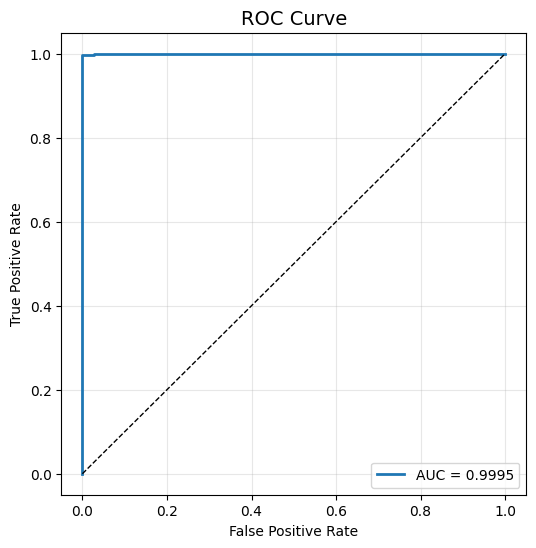

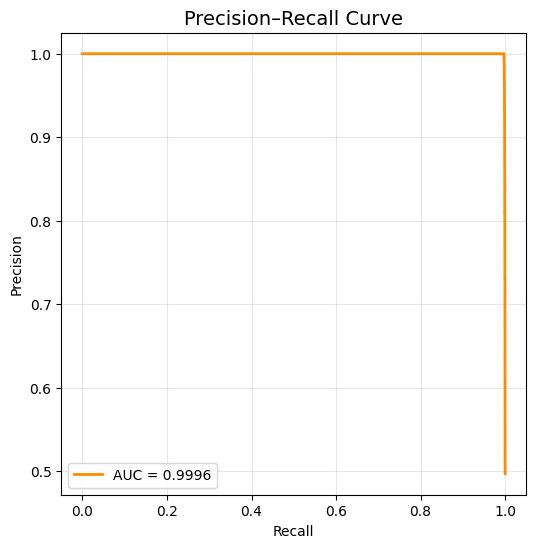

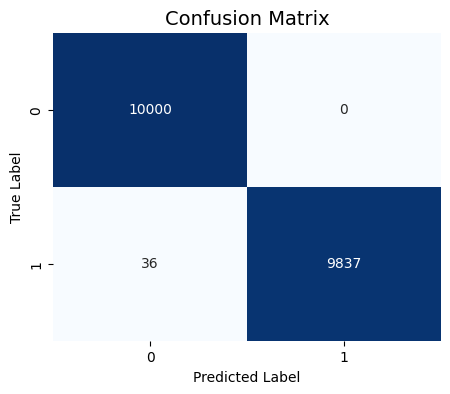

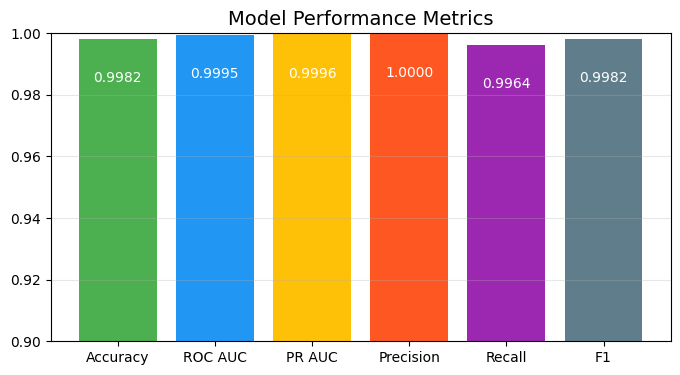

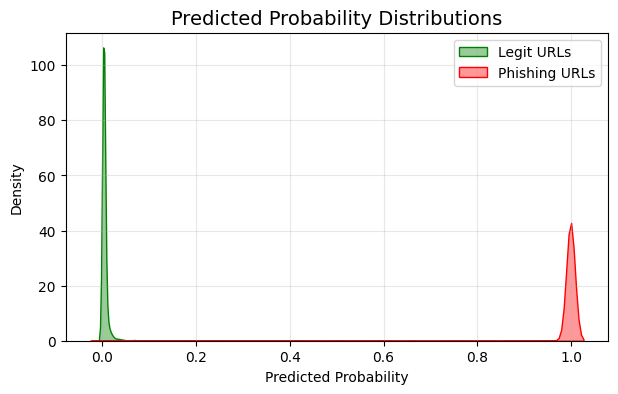

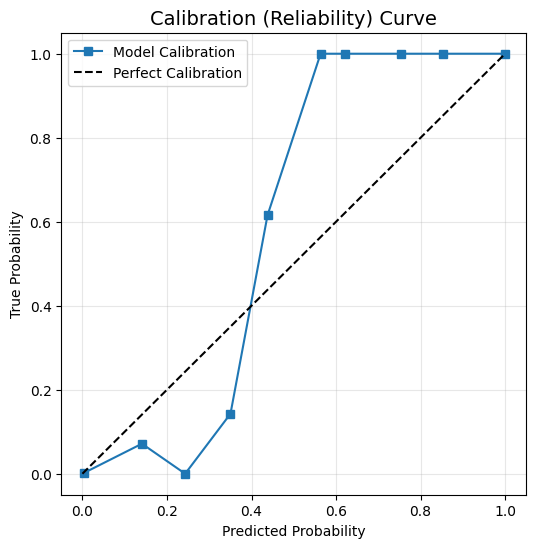

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix,
    auc, RocCurveDisplay, PrecisionRecallDisplay
)
import numpy as np

# y_true and y_prob from your last evaluation
y_true = labels[test_idx]
y_prob = final_prob

# 1️⃣ ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", lw=2)
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.title("ROC Curve", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# 2️⃣ Precision–Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, lw=2, color='darkorange', label=f"AUC = {pr_auc:.4f}")
plt.title("Precision–Recall Curve", fontsize=14)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

# 3️⃣ Confusion Matrix
y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 4️⃣ Metric Summary Bar Chart
metric_names = ["Accuracy", "ROC AUC", "PR AUC", "Precision", "Recall", "F1"]
metric_values = [
    metrics["accuracy"],
    metrics["roc_auc"],
    metrics["pr_auc"],
    metrics["precision"],
    metrics["recall"],
    metrics["f1"]
]

plt.figure(figsize=(8,4))
bars = plt.bar(metric_names, metric_values, color=['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0', '#607D8B'])
plt.ylim(0.9, 1.0)
plt.title("Model Performance Metrics", fontsize=14)
for bar, value in zip(bars, metric_values):
    plt.text(bar.get_x() + bar.get_width()/2, value - 0.015, f"{value:.4f}", ha='center', va='bottom', color='white', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.show()

# 5️⃣ Probability Distribution Plot
plt.figure(figsize=(7,4))
sns.kdeplot(y_prob[y_true==0], label="Legit URLs", fill=True, color="green", alpha=0.4)
sns.kdeplot(y_prob[y_true==1], label="Phishing URLs", fill=True, color="red", alpha=0.4)
plt.title("Predicted Probability Distributions", fontsize=14)
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 6️⃣ Calibration / Reliability Curve (optional)
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, "s-", label="Model Calibration")
plt.plot([0,1],[0,1], "k--", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration (Reliability) Curve", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()